<a href="https://colab.research.google.com/github/Shwetank-Tripathi/ECE/blob/main/DSP_FDM_Project_SemesterV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.fftpack import dct, idct
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt

def fdm(X, fs, fc, data_type='columns', filter_type='dct', sort_fc='descend', remove_mean=False, plot_subbands=True):
    if data_type == 'rows':
        X = np.transpose(X)
    else:
        axis = 0

    if remove_mean:
        X = X - np.mean(X, axis=0)

    N = X.shape[0]
    fc = np.sort(fc)

    if fc[0] != 0:
        fc = np.hstack((0, fc))
    if fc[-1] != fs / 2:
        fc = np.hstack((fc, fs / 2))

    if sort_fc == 'descend':
        fc[::-1].sort()

    if filter_type == 'dct':
        dct_type = 2
        K = np.round(2 * N * fc / fs).astype(int)
        no_of_subbands = K.shape[0] - 1
        Hk = np.zeros((N, 1, no_of_subbands))

    if filter_type == 'dft':
        append_ratio = 0.02
        pad_rows = int(N * append_ratio)
        X_padded = np.pad(X, pad_width=((pad_rows, pad_rows), (0, 0)), mode="symmetric", reflect_type='even')
        appended_length = X_padded.shape[0]
        L = appended_length
        N_fft = 2 * np.ceil(L / 2).astype(int)
        K = np.round(N_fft * fc / fs).astype(int)
        no_of_subbands = K.shape[0] - 1
        Hk = np.zeros((N_fft, 1, no_of_subbands))

    for i in range(no_of_subbands):
        if filter_type == 'dct':
            if sort_fc == 'ascend':
                Hk[K[i]:K[i + 1], :, i] = 1
            if sort_fc == 'descend':
                Hk[K[i + 1]:K[i], :, i] = 1

        if filter_type == 'dft':
            if sort_fc == 'ascend':
                Hk[K[i]:K[i + 1], :, i] = 1
                Hk[N_fft - K[i + 1]:N_fft - K[i], :, i] = 1
            if sort_fc == 'descend':
                Hk[K[i + 1]:K[i], :, i] = 1
                Hk[N_fft - K[i]:N_fft - K[i + 1], :, i] = 1

    if filter_type == 'dct':
        Xk = dct(X, type=dct_type, n=N, axis=axis, norm='ortho')
        Yk = np.einsum('ij,ijk->ijk', Xk, Hk)
        Y = idct(Yk, type=dct_type, n=N, axis=axis, norm='ortho')

    if filter_type == 'dft':
        Xk = 1 / L * fft(X_padded, n=N_fft, axis=axis)
        Yk = np.einsum('ij,ijk->ijk', Xk, Hk)
        Y = L * ifft(Yk, n=N_fft, axis=axis)
        Y = np.real(Y)
        Y = Y[pad_rows + 1:appended_length - pad_rows + 1, :, :]

    if X.shape[1] == 1:
        FIBFs = np.squeeze(Y)
    else:
        FIBFs = Y

    if plot_subbands:
        t = np.arange(0, X.shape[0], 1) / fs
        fc = np.sort(fc)
        if fc[0] != 0:
            fc = [0, fc]
        if fc[-1] != fs / 2:
            fc = [fc, fs / 2]

        if sort_fc == 'descend':
            fc[::-1].sort()

        no_of_subbands = len(fc) - 1
        if no_of_subbands >= 6:
            m = int(np.floor(no_of_subbands / 2)) + 1
            n = 2
        else:
            m = no_of_subbands + 1
            n = 1

        if n == 2:
            plt.figure(figsize=(16, 16))
        else:
            plt.figure(figsize=(8, 16))

        for k in range(no_of_subbands + 1):
            plt.subplot(m, n, k + 1)
            if k == 0:
                plt.plot(t, X[:, 0])
                plt.title('Signal')
            else:
                if X.shape[1] == 1:
                    plt.plot(t, FIBFs[:, k - 1])
                else:
                    plt.plot(t, FIBFs[:, 0, k - 1])

                if sort_fc == 'ascend':
                    plt.title('FIBF {0}: Between {1} Hz to {2} Hz'.format(k, fc[k - 1], fc[k]))
                elif sort_fc == 'descend':
                    plt.title('FIBF {0}: Between {1} Hz to {2} Hz'.format(k, fc[k], fc[k - 1]))

    if data_type == 'rows':
        if X.shape[1] == 1:
            return FIBFs.T
        else:
            return FIBFs.transpose(1, 0, 2)

    return FIBFs


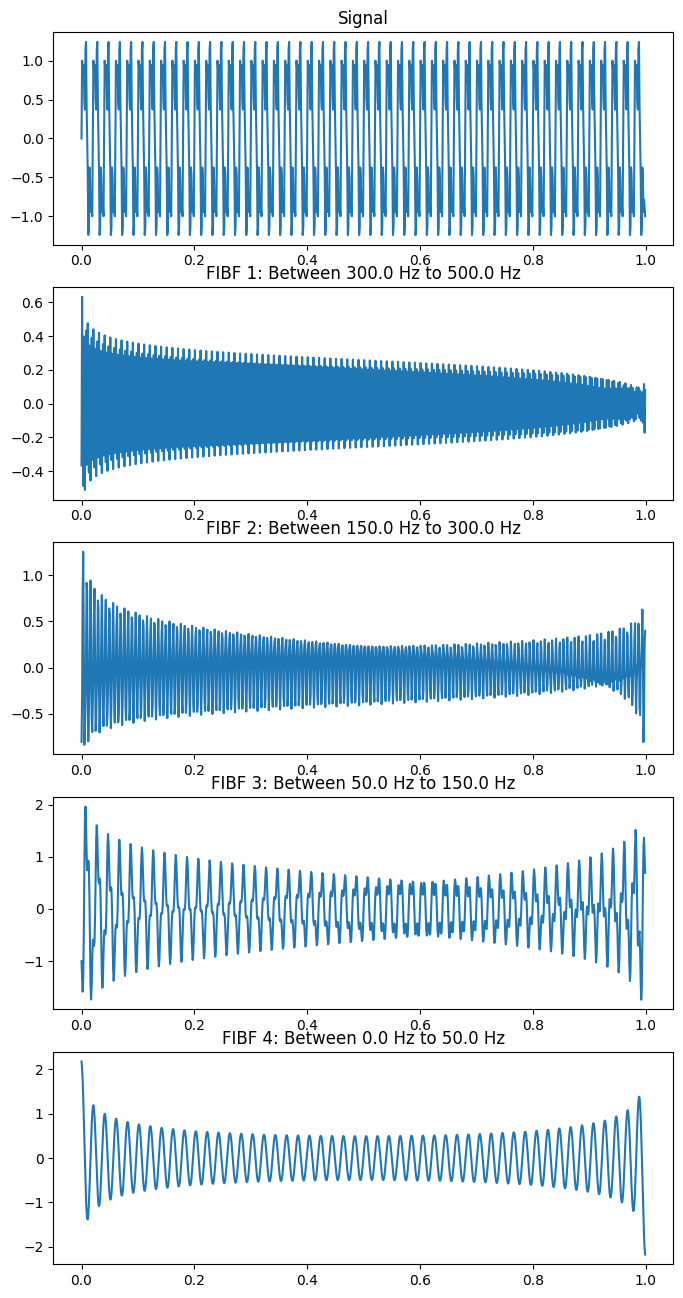

In [2]:
## Sample Input 1

fs = 1000  # Sampling frequency in Hz
t = np.arange(0, 1, 1/fs)  # Time vector from 0 to 1 second
signal = np.sin(2 * np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 150 * t) + 0.3 * np.sin(2 * np.pi * 300 * t)
signal = signal[:, np.newaxis]  # Reshape to match function input requirements

# Define cutoff frequencies for subband filtering
cutoff_frequencies = [50, 150, 300]

# Call the FDM function
FIBFs = fdm(signal, fs, cutoff_frequencies, plot_subbands=True)

# Show plots
plt.show()


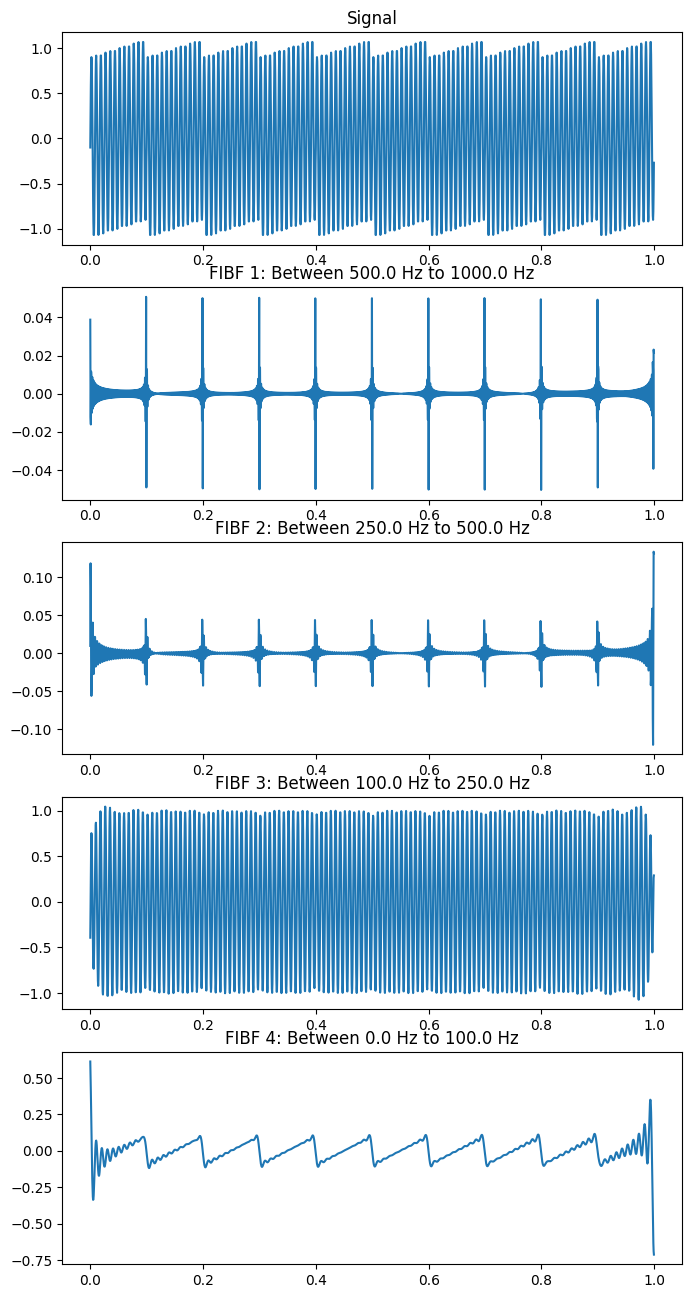

In [3]:
## Sample Input 2

# Generate a triangular wave and a sinusoidal signal
fs = 2000  # Sampling frequency in Hz
t = np.arange(0, 1, 1/fs)  # Time vector for 1 second
tri_wave = 2 * (t % 0.1) - 0.1  # Triangular wave
sin_wave = np.sin(2 * np.pi * 120 * t)  # Sinusoidal wave at 120 Hz
signal = tri_wave + sin_wave
signal = signal[:, np.newaxis]  # Reshape for function input

# Define cutoff frequencies for subband filtering
cutoff_frequencies = [100, 250, 500]

# Call the FDM function
FIBFs = fdm(signal, fs, cutoff_frequencies, filter_type='dft', plot_subbands=True)

# Show the plots
plt.show()


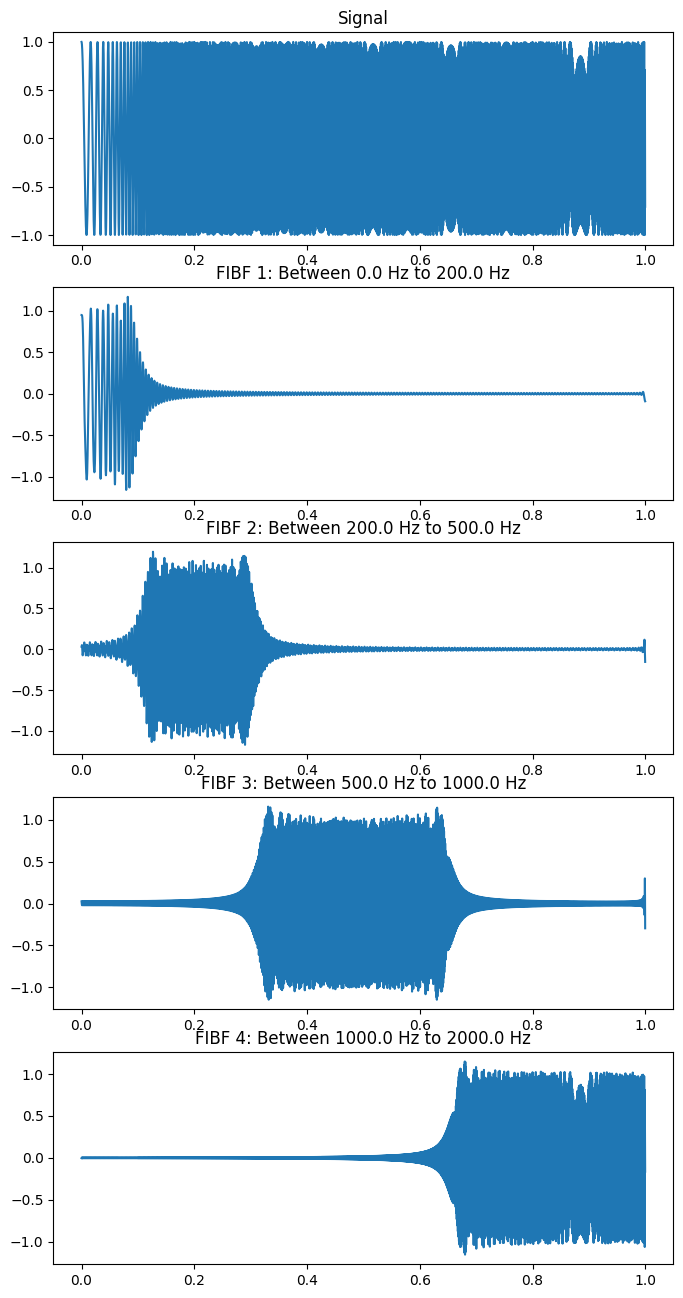

In [4]:
## Sample Input 3
from scipy.signal import chirp

# Parameters for the chirp signal
fs = 4000  # Sampling frequency in Hz
t = np.arange(0, 1, 1/fs)  # Time vector for 1 second
signal = chirp(t, f0=50, f1=1500, t1=1, method='linear')  # Chirp signal
signal = signal[:, np.newaxis]  # Reshape for function input

# Cutoff frequencies for subband filtering
cutoff_frequencies = [200, 500, 1000]

# Call the FDM function
FIBFs = fdm(
    signal,
    fs,
    cutoff_frequencies,
    filter_type='dct',
    data_type='columns',
    remove_mean=True,
    sort_fc='ascend',
    plot_subbands=True
)

# Show the plots
plt.show()
